In [ ]:
import datetime
import multiprocessing
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [ ]:
df = pd.read_csv(
    "/content/SPY.csv",
    header=0
)
df.columns = [x.lower().replace(" ", "_") for x in df.columns]
df.head(5)

,date,open,high,low,close,adj_close,volume
0,2021-07-14,437.399994,437.920013,434.910004,436.239990,430.124481,64130400
1,2021-07-15,434.809998,435.529999,432.720001,434.750000,428.655396,55126400
2,2021-07-16,436.010010,436.059998,430.920013,431.339996,425.293182,75874700
3,2021-07-19,426.190002,431.410004,421.970001,424.970001,419.012512,147987000
4,2021-07-20,425.679993,432.420013,424.829987,431.059998,425.017120,99608200


In [ ]:
df.describe(include="all")

,date,open,high,low,close,adj_close,volume
count,253,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
unique,253,NaN,NaN,NaN,NaN,NaN,NaN
top,2021-07-14,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,437.184230,440.127786,433.808458,437.094665,433.456177,8.965633e+07
std,NaN,26.287933,25.521593,26.834005,26.240536,25.079973,3.597051e+07
min,NaN,365.510010,369.380005,362.170013,365.859985,365.072998,3.484850e+07
25%,NaN,426.190002,431.410004,420.760010,427.809998,424.253662,6.221920e+07
50%,NaN,442.609985,444.730011,439.600006,442.489990,437.558807,8.216830e+07
75%,NaN,454.480011,457.829987,451.459991,453.589996,450.602783,1.126696e+08


In [ ]:
df.dtypes

date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object

In [ ]:
df["date"] = pd.to_datetime(df["date"])

In [ ]:
df = df.sort_values(by="date", ascending=True)

In [ ]:
df.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,date,open,high,low,close,adj_close,volume
count,253,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
unique,253,NaN,NaN,NaN,NaN,NaN,NaN
top,2021-07-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
first,2021-07-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-07-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,437.184230,440.127786,433.808458,437.094665,433.456177,8.965633e+07
std,NaN,26.287933,25.521593,26.834005,26.240536,25.079973,3.597051e+07
min,NaN,365.510010,369.380005,362.170013,365.859985,365.072998,3.484850e+07
25%,NaN,426.190002,431.410004,420.760010,427.809998,424.253662,6.221920e+07


In [ ]:
df.head(15)

,date,open,high,low,close,adj_close,volume
0,2021-07-14,437.399994,437.920013,434.910004,436.239990,430.124481,64130400
1,2021-07-15,434.809998,435.529999,432.720001,434.750000,428.655396,55126400
2,2021-07-16,436.010010,436.059998,430.920013,431.339996,425.293182,75874700
3,2021-07-19,426.190002,431.410004,421.970001,424.970001,419.012512,147987000
4,2021-07-20,425.679993,432.420013,424.829987,431.059998,425.017120,99608200
5,2021-07-21,432.339996,434.700012,431.010010,434.549988,428.458160,64724400
6,2021-07-22,434.739990,435.720001,433.690002,435.459991,429.355438,47878500
7,2021-07-23,437.519989,440.299988,436.790009,439.940002,433.772614,63766600
8,2021-07-26,439.309998,441.029999,439.260010,441.019989,434.837494,43719200
9,2021-07-27,439.910004,439.940002,435.989990,439.010010,432.855682,67397100


In [ ]:
df["open_close_delta"] = df["close"] / df["open"]
df.head()

,date,open,high,low,close,adj_close,volume,open_close_delta
0,2021-07-14,437.399994,437.920013,434.910004,436.239990,430.124481,64130400,0.997348
1,2021-07-15,434.809998,435.529999,432.720001,434.750000,428.655396,55126400,0.999862
2,2021-07-16,436.010010,436.059998,430.920013,431.339996,425.293182,75874700,0.989289
3,2021-07-19,426.190002,431.410004,421.970001,424.970001,419.012512,147987000,0.997137
4,2021-07-20,425.679993,432.420013,424.829987,431.059998,425.017120,99608200,1.012639


In [ ]:
df["day_of_week"] = df["date"].dt.dayofweek
df["day_of_week"] = df["day_of_week"].apply(lambda x: "monday" if x == 0 else x)
df.head(5)

,date,open,high,low,close,adj_close,volume,open_close_delta,day_of_week
0,2021-07-14,437.399994,437.920013,434.910004,436.239990,430.124481,64130400,0.997348,2
1,2021-07-15,434.809998,435.529999,432.720001,434.750000,428.655396,55126400,0.999862,3
2,2021-07-16,436.010010,436.059998,430.920013,431.339996,425.293182,75874700,0.989289,4
3,2021-07-19,426.190002,431.410004,421.970001,424.970001,419.012512,147987000,0.997137,monday
4,2021-07-20,425.679993,432.420013,424.829987,431.059998,425.017120,99608200,1.012639,1


In [ ]:
df = df.drop(['day_of_week'],axis=1)
df.head()

,date,open,high,low,close,adj_close,volume,open_close_delta
0,2021-07-14,437.399994,437.920013,434.910004,436.239990,430.124481,64130400,0.997348
1,2021-07-15,434.809998,435.529999,432.720001,434.750000,428.655396,55126400,0.999862
2,2021-07-16,436.010010,436.059998,430.920013,431.339996,425.293182,75874700,0.989289
3,2021-07-19,426.190002,431.410004,421.970001,424.970001,419.012512,147987000,0.997137
4,2021-07-20,425.679993,432.420013,424.829987,431.059998,425.017120,99608200,1.012639


In [ ]:
df["return"] = df["adj_close"] / df["adj_close"].shift(1)
df["label"] = df["return"].shift(-1) # today's features are used to forecast tomorrow's return

# setup label as a classification problem {0, 1}
df["label"] = df["label"].apply(lambda x: 1.0 if x > 1.005 else 0.0) 
# if close/open is bigger than 1.005 that means there's a benefit,
# otherwise there is not much so labelled as zero. 
print(df.loc[:, ["date", "adj_close", "return", "label"]].head(5))
print(df["label"].value_counts(ascending=False))

        date   adj_close    return  label
0 2021-07-14  430.124481       NaN    0.0
1 2021-07-15  428.655396  0.996585    0.0
2 2021-07-16  425.293182  0.992156    0.0
3 2021-07-19  419.012512  0.985232    1.0
4 2021-07-20  425.017120  1.014330    1.0
0.0    179
1.0     74
Name: label, dtype: int64


In [ ]:
import plotly.graph_objects as go

df_plt = df.set_index("date")
fig = go.Figure(data=[go.Candlestick(x=df.index, open=df['open'], high=df['high'], low=df['low'], close=df['close'] )])
fig.show()

In [ ]:
maxValue=df[df['close']==max(df.close)]
print("Highiest value of yahoo finance:")
maxValue

Highiest value of yahoo finance:


,date,open,high,low,close,adj_close,volume,open_close_delta,return,label
120,2022-01-03,476.299988,477.850006,473.850006,477.709991,474.18219,72668200,1.00296,1.00579,0.0


In [ ]:
df.loc[119]

date                2021-12-31 00:00:00
open                         475.640015
high                         476.859985
low                          474.670013
close                        474.959991
adj_close                    471.452484
volume                         65237400
open_close_delta                0.99857
return                          0.99748
label                               1.0
Name: 119, dtype: object

In [ ]:
def to2021(df):
  df21=equalize(df,df)
  return df22.iloc[0:120]

def to2022(df):
  df22=equalize(df,df)
  return df22.iloc[120:]

def equalize(df,dfs):
  low=len(dfs)
  high=len(df)
  dff=high-low
  return df.iloc[dff:]

In [ ]:
df21 = to2021(df)
df22 = to2022(df)

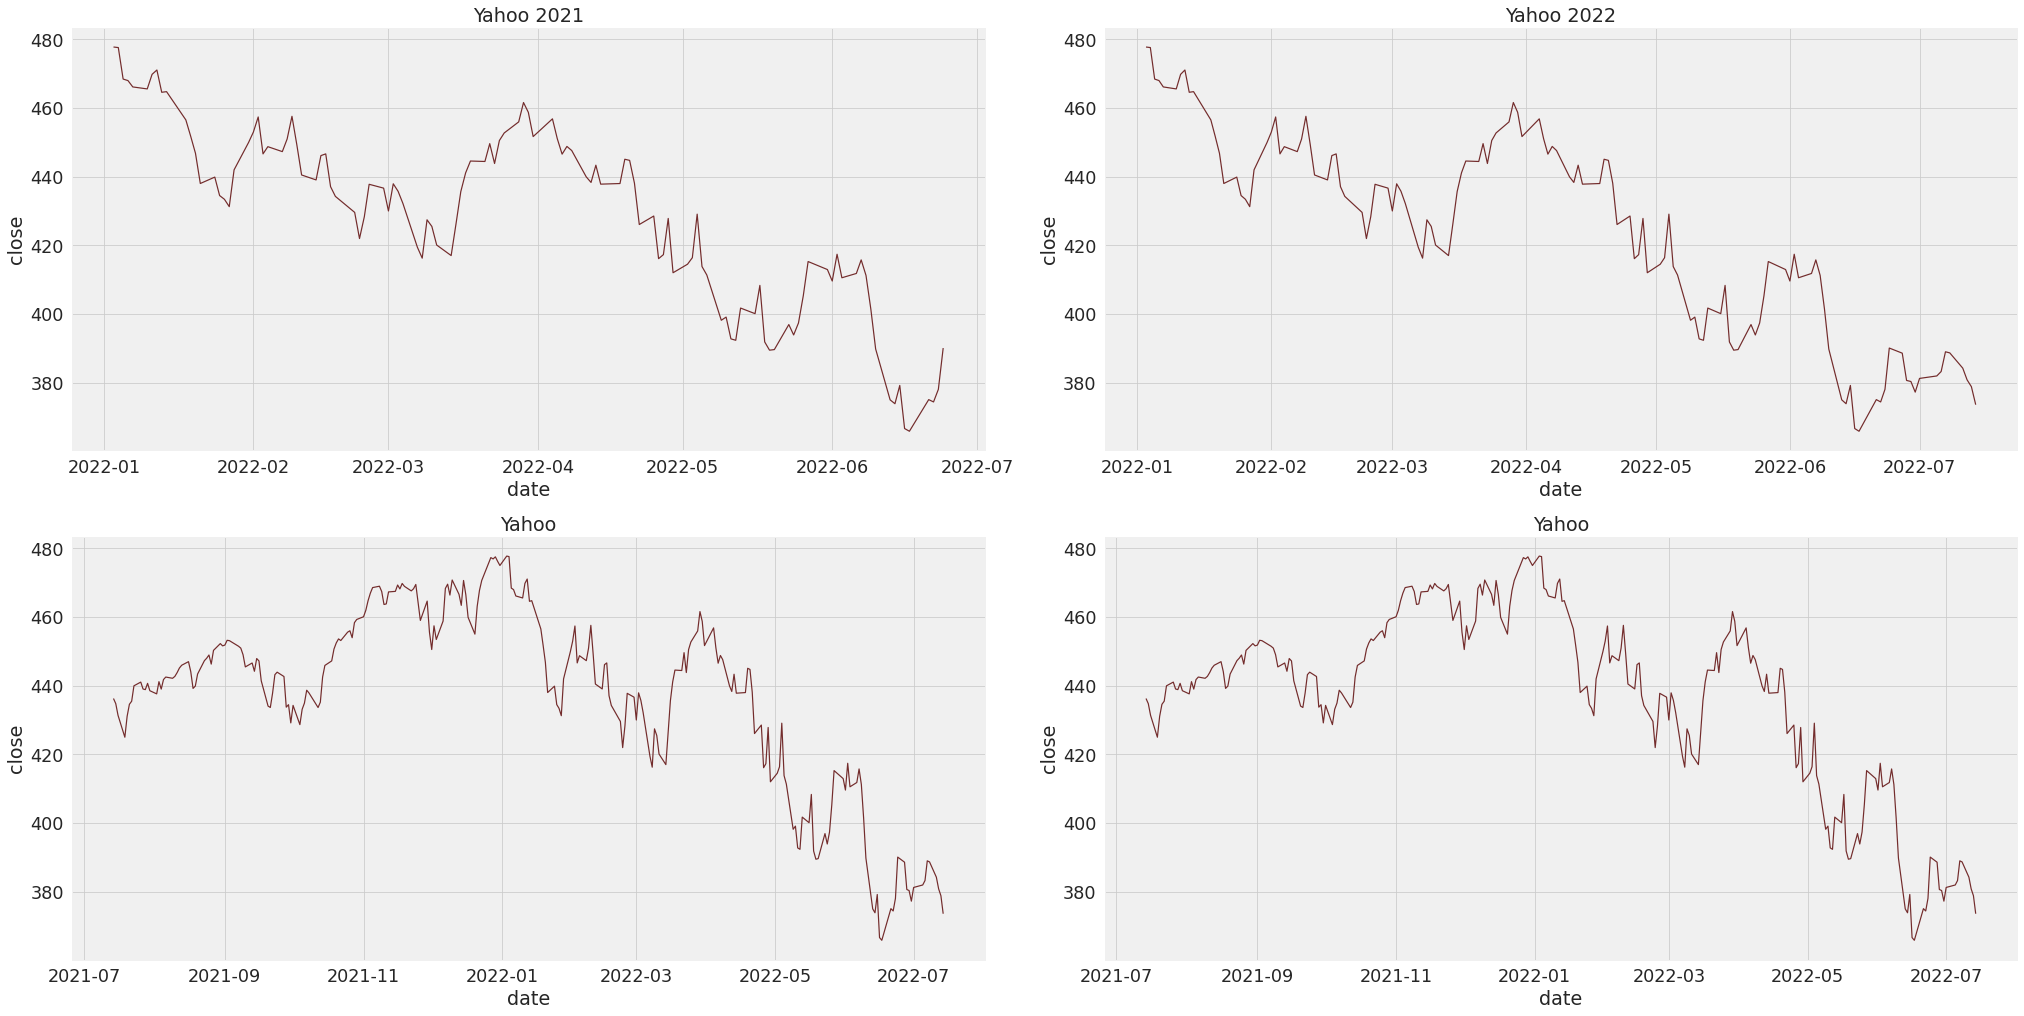

In [ ]:
finance =["Yahoo 2021","Yahoo 2022",'Yahoo','Yahoo']
financedf =[df21,df22,df,df]
num_plots = 6
total_cols = 2
total_rows = 2
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(14*total_cols, 7*total_rows), constrained_layout=True)
for i, var in enumerate(finance):
  row = i//total_cols
  pos = i % total_cols
  sns.set_context('paper', font_scale = 2)
  plot =  sns.lineplot(data=financedf[i], x="date", y="close",color='#732C2C',palette ='coolwarm',ax=axs[row][pos])
  axs[row][pos].set_title(finance[i])

Observation

    We can see a clear spike in all the cryptocurrency in 2018
    After 2018, prices started falling
    The nature of spikes is the same in all the cryptocurrency
    Bitconnect fell definitely and stopped to present after that.
    Though Bitcoin and Ethereum both endure the effect is as yet on the lookout



# Machine Learning 

In [ ]:
train_df = df.loc[pd.Timestamp("2022-04-12") >= df["date"], :]
print(len(train_df))
print(train_df["date"].describe())
test_df = df.loc[pd.Timestamp("2022-04-12") < df["date"], :]
print(len(test_df))
print(test_df["date"].describe())

190
count                     190
unique                    190
top       2021-07-14 00:00:00
freq                        1
first     2021-07-14 00:00:00
last      2022-04-12 00:00:00
Name: date, dtype: object
63
count                      63
unique                     63
top       2022-04-13 00:00:00
freq                        1
first     2022-04-13 00:00:00
last      2022-07-14 00:00:00
Name: date, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



In [ ]:
y_train = train_df['label'].values

In [ ]:
X_train = train_df[['open','high','low','close','adj_close','volume','open_close_delta','return']].values

array([[4.37399994e+02, 4.37920013e+02, 4.34910004e+02, ...,
        6.41304000e+07, 9.97347956e-01,            nan],
       [4.34809998e+02, 4.35529999e+02, 4.32720001e+02, ...,
        5.51264000e+07, 9.99862013e-01, 9.96584512e-01],
       [4.36010010e+02, 4.36059998e+02, 4.30920013e+02, ...,
        7.58747000e+07, 9.89289205e-01, 9.92156371e-01],
       ...,
       [4.47970001e+02, 4.50630005e+02, 4.45940002e+02, ...,
        7.92727000e+07, 9.99107096e-01, 9.97326055e-01],
       [4.44109985e+02, 4.45000000e+02, 4.39390015e+02, ...,
        8.97705000e+07, 9.90565463e-01, 9.82907705e-01],
       [4.43079987e+02, 4.45750000e+02, 4.36649994e+02, ...,
        8.43636000e+07, 9.89189361e-01, 9.96294788e-01]])

In [ ]:
imp = SimpleImputer(strategy="most_frequent")
X_train = np.array(imp.fit_transform(train_df[['open','high','low','close','adj_close','volume','open_close_delta','return']]))
X_train

array([[4.37399994e+02, 4.37920013e+02, 4.34910004e+02, ...,
        6.41304000e+07, 9.97347956e-01, 9.70520820e-01],
       [4.34809998e+02, 4.35529999e+02, 4.32720001e+02, ...,
        5.51264000e+07, 9.99862013e-01, 9.96584512e-01],
       [4.36010010e+02, 4.36059998e+02, 4.30920013e+02, ...,
        7.58747000e+07, 9.89289205e-01, 9.92156371e-01],
       ...,
       [4.47970001e+02, 4.50630005e+02, 4.45940002e+02, ...,
        7.92727000e+07, 9.99107096e-01, 9.97326055e-01],
       [4.44109985e+02, 4.45000000e+02, 4.39390015e+02, ...,
        8.97705000e+07, 9.90565463e-01, 9.82907705e-01],
       [4.43079987e+02, 4.45750000e+02, 4.36649994e+02, ...,
        8.43636000e+07, 9.89189361e-01, 9.96294788e-01]])

In [ ]:
y_test = test_df['label'].values
imp = SimpleImputer(strategy="most_frequent")
X_test = np.array(imp.fit_transform(test_df[['open','high','low','close','adj_close','volume','open_close_delta','return']]))

In [ ]:
from sklearn.preprocessing import StandardScaler

# simple preprocessing of the data 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

# implement basic ML baseline (one per asset)
lr = LogisticRegression()
lr.fit(X_train_scaled,y_train)
y_pred_lr_btc = lr.predict(X_test_scaled)

lr.fit(X_train_scaled,y_train)
lr.score(X_test_scaled,y_test)

0.36507936507936506

In [ ]:
# implement more complex baseline (multiple output regression model)
from sklearn.multioutput import MultiOutputClassifier

# we concatenate X and y for both assets
X_both_train = np.concatenate((X_train_scaled, X_train_scaled), axis=1)
X_both_test = np.concatenate((X_test_scaled, X_test_scaled), axis=1)
y_both_train = np.column_stack((y_train, y_train))
y_both_test = np.column_stack((y_test, y_test))

# define the direct multioutput model and fit it
mlr = MultiOutputClassifier(LogisticRegression())
lr.fit(X_train_scaled,y_train)
lr.score(X_test,y_test)

0.30158730158730157

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.5873015873015873

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.4126984126984127

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.5079365079365079

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(5, 2), random_state=1,max_iter=10000)

clf.fit(X_train,y_train)
clf.score(X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



0.30158730158730157

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.6984126984126984

In [ ]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(svm.SVC(),max_samples=0.5, max_features=0.5)

bagging.fit(X_train,y_train)
bagging.score(X_test,y_test)

0.6984126984126984